# Subnetwork Controllability, Aging, and TIA effects
Similar to the whole-brain ctrb analysis, except we calculate mean controllability of a subset of nodes grouped based on their functional subnetwork assignment. This assignment was determined by pre-existing atlas since we do not have associated functional networks for this dataset.

In [1]:
import math
import networkx as nx
import pandas as pd
import numpy as np
import importlib
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
print(sys.version)

import Towlson_group_code.data_io as myFunc
importlib.reload(myFunc)

import PREVENT_functions as prev_fct
importlib.reload(prev_fct)

PICKLE_PATH = '../../PREVENT_Study/pickles/'
FIGURE_PATH = '../../PREVENT_Study/figures/'
DUMP_PATH = '../../PREVENT_Study/dump/'
TIMES = ['BL', 'Y1', 'Y3', 'Y5']
metadata, node_list = prev_fct.load_meta_data()
print(len(node_list))
individual_data = myFunc.load_from_pickle(PICKLE_PATH, 'Normalized_Connectomes.pkl')

color_map = {"BL": '#1f77b4', "Y1": '#ff7f0e', "Y3": '#2ca02c', "Y5": '#d62728'}

# Subnetwork atlas from a spreadsheet
node_icn_map, icn_node_map = prev_fct.get_icn_map()

3.8.12 (default, Mar  1 2023, 16:37:51) 
[Clang 13.1.6 (clang-1316.0.21.2.5)]
150


In [7]:
metadata[metadata['C/T'] == "HC"].count()

Unnamed: 0                    186
Age                           186
C/T                           186
Gender                        186
education_yrs                 166
MRI Date BL                   120
MRI Date Y1                    89
MRI Date Y3                    36
MRI Date Y5                    30
Time Between BL and 1-Yr       56
Time Between 1-Yr and 3-yr     22
Time Between 3-Yr and 5-Yr     14
Time Between BL and 5-Yr       12
Time Between BL and 3-Yr       16
dtype: int64

In [8]:
metadata[metadata['C/T'] == "P"].count()

Unnamed: 0                    238
Age                           238
C/T                           238
Gender                        238
education_yrs                 204
MRI Date BL                   227
MRI Date Y1                   126
MRI Date Y3                    18
MRI Date Y5                    30
Time Between BL and 1-Yr      125
Time Between 1-Yr and 3-yr     11
Time Between 3-Yr and 5-Yr      8
Time Between BL and 5-Yr       30
Time Between BL and 3-Yr       18
dtype: int64

In [2]:
pType_convert = {"HC": "Control", "P": "TIA"}
def get_ctrb_df(rois, use_rank = False):
    age_years_map = {'BL': 0, 'Y1': 1, 'Y3': 3, 'Y5': 5}
    ids = []
    time = []
    age = []
    diagnosis = []
    avg_ctrb = []
    mod_ctrb = []
    for k in individual_data.keys():
        if len(k) == 4:
            ptype = k[:2]
            t = k[2:].upper()
        else:
            ptype = k[0]
            t = k[1:].upper()
        for pid, G in individual_data[k].items():
            diagnosis.append(pType_convert[ptype])
            ids.append(pid)
            time.append(t)
            age.append(metadata.loc[pid]['Age'] + age_years_map[t])
            if use_rank:
                _, G, _ = prev_fct.rank_nodes(G, 'avgCtrb')
                _, G, _ = prev_fct.rank_nodes(G, 'modCtrb')
                avg_ctrb.append(prev_fct.get_avg_node_metric(G, rois, 'avgCtrbRank'))
                mod_ctrb.append(prev_fct.get_avg_node_metric(G, rois, 'modCtrbRank'))
            else:
                avg_ctrb.append(prev_fct.get_avg_node_metric(G, rois, 'avgCtrb'))
                mod_ctrb.append(prev_fct.get_avg_node_metric(G, rois, 'modCtrb'))
    return pd.DataFrame(data = {'ID': ids, 'Time': time, 'C/T': diagnosis, 'Age': age, 'avgCtrb': avg_ctrb, 'modCtrb': mod_ctrb})

# Cross-sectional analysis
Functional network (FN) controllability changes. FN Controllability is defined as the average of all nodal controllability in the FN.
- To prevent the problem of having non-independent datapoints, we will separate out baseline, 1-year, 3-year, and 5-year data based on color.
- Since this is not looking at rate of change, all available data points are used.
- $x$ = time (BL, Y1, Y3, Y5), $y$ = FN controllability, color by group (Control vs TIA)

In [3]:
subnetwork_ctrb_df = None

for icn_name, icn_nodes in icn_node_map.items():
    temp_df = get_ctrb_df(icn_nodes)
    temp_df["Functional Network"] = [icn_name.capitalize()]*len(temp_df.index)
    if subnetwork_ctrb_df is None:
        subnetwork_ctrb_df = temp_df
    else:
        subnetwork_ctrb_df = pd.concat([subnetwork_ctrb_df, temp_df])

subnetwork_ctrb_df = subnetwork_ctrb_df.rename(columns={"avgCtrb": "Avg. Ctrb.", "modCtrb": "Modal Ctrb."})
subnetwork_ctrb_df.head(5)

,ID,Time,C/T,Age,Avg. Ctrb.,Modal Ctrb.,Functional Network
0,118,BL,Control,61,1.071150,0.957643,Auditory
1,103,BL,Control,44,1.143262,0.925726,Auditory
2,088,BL,Control,68,1.074521,0.959506,Auditory
3,093,BL,Control,63,1.101124,0.941241,Auditory
4,213,BL,Control,60,1.202441,0.920660,Auditory


In [5]:
ICN_list = list(subnetwork_ctrb_df['Functional Network'].unique())
ICN_list

['Auditory',
 'Dorsal attention',
 'Somatosensory',
 'Fronto-parietal',
 'Other',
 'Default mode',
 'Visual',
 'Cingulo-opercular',
 'Ventral attention',
 'Somatosensory-motor']

### Subnetwork Average Controllability Cross-section differences
Average Controllability

| FN                | p-value          | Time |
|-------------------|------------------|------|
| AUD               | $p' = 1.029e-09$ | BL |
| FPN               | $p' = 4.61e-07$   | BL |
| Cingulo-opercular | $p = 0.0121$     | BL |
| vATN              | $p' = 0.0069339$ | BL |

In [16]:
from scipy.stats import mannwhitneyu

for idx, icn in enumerate(ICN_list):
    print(icn, idx)
    for time_group in TIMES:
        fn_df = subnetwork_ctrb_df[subnetwork_ctrb_df["Functional Network"] == icn]
        fn_time_subset_df = fn_df[fn_df["Time"] == time_group]
        control_subset = fn_time_subset_df[fn_time_subset_df["C/T"] == "Control"]
        tia_subset = fn_time_subset_df[fn_time_subset_df["C/T"] == "TIA"]

        _, p = mannwhitneyu(control_subset["Avg. Ctrb."], tia_subset["Avg. Ctrb."], method='asymptotic', alternative="two-sided")
        p_adj = p*len(TIMES)*len(ICN_list)
        if p_adj < 0.05:
            print(time_group, p_adj)
    print()

Auditory 0
BL 1.0295449988861503e-09

Dorsal attention 1

Somatosensory 2

Fronto-parietal 3
BL 4.6088988267975854e-07

Other 4

Default mode 5

Visual 6

Cingulo-opercular 7

Ventral attention 8
BL 0.006933929291840602

Somatosensory-motor 9



Text(0.5, 1.0, 'Visual')

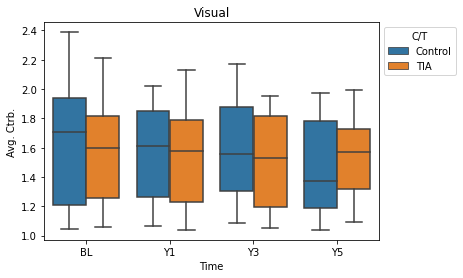

In [76]:
icn = ICN_list[6]
fn_df = subnetwork_ctrb_df[subnetwork_ctrb_df["Functional Network"] == icn]

plot = sns.boxplot(data=fn_df, x="Time", y="Avg. Ctrb.", hue="C/T", showfliers = False)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plot.set_title(icn)
# plt.savefig(FIGURE_PATH+f"/new analysis/{icn} Average Controllability.png", dpi=250, bbox_inches='tight')

### Subnetwork Modal Controllability Cross-section differences
Modal Controllability

| FN                | p-value           | Time |
|-------------------|-------------------|------|
| AUD               | $p = 1.02518e-11$ | BL   |
| AUD               | $p = 0.01430568$ | Y1   |
| AUD               | $p = 0.0279585$ | Y5   |
| dATN              | $p = 0.032615$   | BL   |
| FPN               | $p = 2.7983e-06$  | BL   |
| Cingulo-opercular | $p = 0.0005435$  | BL   |
| vATN              | $p = 0.0001788$  | BL   |

In [15]:
for idx, icn in enumerate(ICN_list):
    print(icn, idx)
    for time_group in TIMES:
        fn_df = subnetwork_ctrb_df[subnetwork_ctrb_df["Functional Network"] == icn]
        fn_time_subset_df = fn_df[fn_df["Time"] == time_group]
        control_subset = fn_time_subset_df[fn_time_subset_df["C/T"] == "Control"]
        tia_subset = fn_time_subset_df[fn_time_subset_df["C/T"] == "TIA"]

        _, p = mannwhitneyu(control_subset["Modal Ctrb."], tia_subset["Modal Ctrb."], method='asymptotic', alternative="two-sided")
        p_adj = p*len(TIMES)*len(ICN_list)
        if p_adj < 0.05:
            print(time_group, p_adj)
    print()

Auditory 0
BL 4.1007087420271957e-10

Dorsal attention 1

Somatosensory 2

Fronto-parietal 3
BL 0.00011193218347827494

Other 4

Default mode 5

Visual 6

Cingulo-opercular 7
BL 0.021740744766592986

Ventral attention 8
BL 0.00715324750570675

Somatosensory-motor 9



Text(0.5, 1.0, 'Visual')

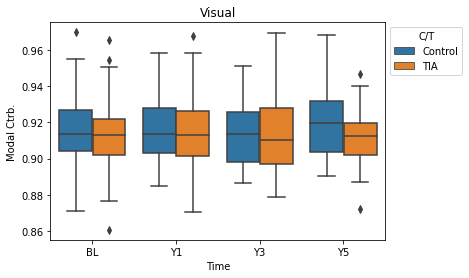

In [77]:
icn = ICN_list[6]
fn_df = subnetwork_ctrb_df[subnetwork_ctrb_df["Functional Network"] == icn]

plot = sns.boxplot(data=fn_df, x="Time", y="Modal Ctrb.", hue="C/T")
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plot.set_title(icn)
# plt.savefig(FIGURE_PATH+f"/new analysis/{icn} Modal Controllability.png", dpi=250, bbox_inches='tight')

# Longitudinal analysis: LME
For this section, we will export/prep data to be modelled in **SPSS statistics**.

- [ ] (1) $y =$ FN ctrb, $x =$ age, covariates = gender, education
- [ ] (2) $y = Cog Score$, $x = $ age
- [ ] (3) $y = Cog Score$, $x = $ FN modal ctrb

Export data for (1) to perform LME in SPSS.

In [64]:
subnetwork_ctrb_df.head(5)

,ID,Time,C/T,Age,Avg. Ctrb.,Modal Ctrb.,Functional Network
0,118,BL,Control,61,1.071150,0.957643,Auditory
1,103,BL,Control,44,1.143262,0.925726,Auditory
2,088,BL,Control,68,1.074521,0.959506,Auditory
3,093,BL,Control,63,1.101124,0.941241,Auditory
4,213,BL,Control,60,1.202441,0.920660,Auditory


In [9]:
export_df = subnetwork_ctrb_df.rename(columns={
    "Avg. Ctrb.": "AvgCtrb",
    "Modal Ctrb.": "ModalCtrb",
    "Functional Network": "Fn",
    "C/T": "Group",
    "Age": "Age",
    "Time": "Time",
    "ID": "Id"})

export_df.head(5)

,Id,Time,Group,Age,AvgCtrb,ModalCtrb,Fn
0,118,BL,Control,61,1.071150,0.957643,Auditory
1,103,BL,Control,44,1.143262,0.925726,Auditory
2,088,BL,Control,68,1.074521,0.959506,Auditory
3,093,BL,Control,63,1.101124,0.941241,Auditory
4,213,BL,Control,60,1.202441,0.920660,Auditory


Add in Biological sex and education years data points

In [10]:
gender = []
education = []
for pid in export_df["Id"]:
    gender.append(metadata.loc[pid]["Gender"])
    education.append(metadata.loc[pid]["education_yrs"])

export_df["EducationYrs"] = education
export_df["BioSex"] = gender
export_df.head(5)

,Id,Time,Group,Age,AvgCtrb,ModalCtrb,Fn,EducationYrs,BioSex
0,118,BL,Control,61,1.071150,0.957643,Auditory,16.0,M
1,103,BL,Control,44,1.143262,0.925726,Auditory,16.0,M
2,088,BL,Control,68,1.074521,0.959506,Auditory,12.0,M
3,093,BL,Control,63,1.101124,0.941241,Auditory,12.0,F
4,213,BL,Control,60,1.202441,0.920660,Auditory,14.0,F


In [8]:
# export_df["BioSex"].replace("M", 0, inplace=True)
# export_df["BioSex"].replace("F", 1, inplace=True)
# export_df["Group"].replace("Control", 0, inplace=True)
# export_df["Group"].replace("TIA", 1, inplace=True)
# export_df.head(5)

,Id,Time,Group,Age,AvgCtrb,ModalCtrb,Fn,EducationYrs,BioSex
0,118,BL,0,61,1.071150,0.957643,Auditory,16.0,0
1,103,BL,0,44,1.143262,0.925726,Auditory,16.0,0
2,088,BL,0,68,1.074521,0.959506,Auditory,12.0,0
3,093,BL,0,63,1.101124,0.941241,Auditory,12.0,1
4,213,BL,0,60,1.202441,0.920660,Auditory,14.0,1


In [18]:
icn = ICN_list[6]
export_df[export_df["Fn"] == icn].to_csv(f'../../PREVENT_Study/dump/{icn}_ctrb_aging.csv')


# Subnetwork Controllability and Cognitive scores
- Longitudinal analysis: LME modelling in R.
- Already have everything. Just need to pull in cog. test score data.

In [7]:
AUD = ICN_list[0]
FPN = ICN_list[3]
VIS = ICN_list[6]
CON = ICN_list[7]

cognitive_domains_map = {'visual memory': ['bvmt_total_recall', 'bvmt_delayed_recall'],
                'verbal memory': ['ravlt_list_a_delay_recall'],
                'processing speed': ['tmt_trail_a_time'],
                'executive function': ['tmt_trail_b_time', 'wais_r_total'],
                'premorbid IQ': ['naart_total']}

def loadBehaviorData(sheetname):
    # behavior_df = pd.read_excel('../PREVENT_Study/data/PREVENT_Data_Xining_Oct_2022.xlsx', sheet_name=sheetname, index_col=None, header=0)
    behavior_df = pd.read_excel('../../PREVENT_Study/data/cognitive_scores.xlsx', sheet_name=sheetname.lower(), index_col=None, header=0)
    ids = []
    for i in behavior_df['ID']:
        id = str(i)
        if len(id) < 3:
            id = '0'*(3-len(id))+id
        ids.append(id)
    behavior_df['ID'] = ids
    behavior_df = behavior_df.drop(['tmt_trail_b_dn', 'tmt_trail_a_dn'], axis=1)
    behavior_df = behavior_df.set_index(['ID'])
    return behavior_df

bl_score = loadBehaviorData('bl')
y1_score = loadBehaviorData('y1')
y3_score = loadBehaviorData('y3')
y5_score = loadBehaviorData('y5')

subnetwork_ctrb_df = None

for icn_name, icn_nodes in icn_node_map.items():
    temp_df = get_ctrb_df(icn_nodes)
    temp_df["Functional Network"] = [icn_name.capitalize()]*len(temp_df.index)
    if subnetwork_ctrb_df is None:
        subnetwork_ctrb_df = temp_df
    else:
        subnetwork_ctrb_df = pd.concat([subnetwork_ctrb_df, temp_df])

# subnetwork_ctrb_df.drop(columns=['avgCtrb'], inplace=True)
subnetwork_ctrb_df['Functional Network'].unique()

array(['Auditory', 'Dorsal attention', 'Somatosensory', 'Fronto-parietal',
       'Other', 'Default mode', 'Visual', 'Cingulo-opercular',
       'Ventral attention', 'Somatosensory-motor'], dtype=object)

### Visual memory

In [63]:
fpn_ctrb_df = subnetwork_ctrb_df[subnetwork_ctrb_df["Functional Network"] == FPN]
fpn_ctrb_df.rename(columns={"modCtrb": "FPN"}, inplace=True)
fpn_ctrb_df.drop(columns=["Functional Network"], inplace=True)

vis_ctrb_df = subnetwork_ctrb_df[subnetwork_ctrb_df["Functional Network"] == VIS]
vis_ctrb_df.rename(columns={"modCtrb": "VIS"}, inplace=True)
vis_ctrb_df.drop(columns=["Functional Network", "C/T", "Age"], inplace=True)

vis_memory_ctrb_df = fpn_ctrb_df.merge(vis_ctrb_df, left_on=['ID', 'Time'], right_on=['ID', 'Time'], suffixes=(False, False))
# vis_memory_ctrb_df.tail(5)
vis_memory_ctrb_df.head(5)

/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2357/4116234601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpn_ctrb_df.rename(columns={"modCtrb": "FPN"}, inplace=True)
/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2357/4116234601.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpn_ctrb_df.drop(columns=["Functional Network"], inplace=True)
/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2357/4116234601.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,ID,Time,C/T,Age,FPN,VIS
0,118,BL,Control,61,0.946620,0.924374
1,103,BL,Control,44,0.946897,0.909372
2,088,BL,Control,68,0.959859,0.902101
3,093,BL,Control,63,0.968023,0.926139
4,213,BL,Control,60,0.939988,0.901556


Add Bio sex and education years

In [ ]:
gender = []
education = []
for pid in vis_memory_ctrb_df["ID"]:
    gender.append(metadata.loc[pid]["Gender"])
    education.append(metadata.loc[pid]["education_yrs"])

vis_memory_ctrb_df["EducationYrs"] = education
vis_memory_ctrb_df["BioSex"] = gender

Add test score and premorbid IQ

In [ ]:
cog_score = []
iq_score = []
test_name = 'bvmt_delayed_recall'
iq_name = 'naart_total'
for ri, row in vis_memory_ctrb_df.iterrows():
    pid = row['ID']
    time = row['Time'].upper()
    if time == 'BL':
        cog_score.append(bl_score.loc[pid][test_name])
        iq_score.append(bl_score.loc[pid][iq_name])
    elif time == 'Y1':
        cog_score.append(y1_score.loc[pid][test_name])
        iq_score.append(y1_score.loc[pid][iq_name])
    elif time == 'Y3':
        cog_score.append(y3_score.loc[pid][test_name])
        iq_score.append(y3_score.loc[pid][iq_name])
    elif time == 'Y5':
        cog_score.append(y5_score.loc[pid][test_name])
        iq_score.append(y5_score.loc[pid][iq_name])

vis_memory_ctrb_df['CogScore'] = cog_score
vis_memory_ctrb_df['Iq'] = iq_score

vis_memory_ctrb_df = vis_memory_ctrb_df.dropna()

In [ ]:
vis_memory_ctrb_df.rename(columns = {"C/T": "Group"}, inplace=True)
vis_memory_ctrb_df.to_csv('../../PREVENT_Study/dump/vis_memory_ctrb.csv')

### Verbal memory

In [69]:
fpn_ctrb_df = subnetwork_ctrb_df[subnetwork_ctrb_df["Functional Network"] == FPN]
fpn_ctrb_df.rename(columns={"modCtrb": "FPN"}, inplace=True)
fpn_ctrb_df.drop(columns=["Functional Network"], inplace=True)

aud_ctrb_df = subnetwork_ctrb_df[subnetwork_ctrb_df["Functional Network"] == AUD]
aud_ctrb_df.rename(columns={"modCtrb": "AUD"}, inplace=True)
aud_ctrb_df.drop(columns=["Functional Network", "C/T", "Age"], inplace=True)

verbal_memory_ctrb_df = fpn_ctrb_df.merge(aud_ctrb_df, left_on=['ID', 'Time'], right_on=['ID', 'Time'], suffixes=
(False, False))
# vis_memory_ctrb_df.tail(5)
verbal_memory_ctrb_df.head(5)

/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2357/4179163202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpn_ctrb_df.rename(columns={"modCtrb": "FPN"}, inplace=True)
/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2357/4179163202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpn_ctrb_df.drop(columns=["Functional Network"], inplace=True)
/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2357/4179163202.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,ID,Time,C/T,Age,FPN,AUD
0,118,BL,Control,61,0.946620,0.957643
1,103,BL,Control,44,0.946897,0.925726
2,088,BL,Control,68,0.959859,0.959506
3,093,BL,Control,63,0.968023,0.941241
4,213,BL,Control,60,0.939988,0.920660


Add Bio sex and education years

In [70]:
gender = []
education = []
for pid in verbal_memory_ctrb_df["ID"]:
    gender.append(metadata.loc[pid]["Gender"])
    education.append(metadata.loc[pid]["education_yrs"])

verbal_memory_ctrb_df["EducationYrs"] = education
verbal_memory_ctrb_df["BioSex"] = gender

Add test score and premorbid IQ

In [71]:
cog_score = []
iq_score = []
test_name = 'ravlt_list_a_delay_recall'
iq_name = 'naart_total'
for ri, row in verbal_memory_ctrb_df.iterrows():
    pid = row['ID']
    time = row['Time'].upper()
    if time == 'BL':
        cog_score.append(bl_score.loc[pid][test_name])
        iq_score.append(bl_score.loc[pid][iq_name])
    elif time == 'Y1':
        cog_score.append(y1_score.loc[pid][test_name])
        iq_score.append(y1_score.loc[pid][iq_name])
    elif time == 'Y3':
        cog_score.append(y3_score.loc[pid][test_name])
        iq_score.append(y3_score.loc[pid][iq_name])
    elif time == 'Y5':
        cog_score.append(y5_score.loc[pid][test_name])
        iq_score.append(y5_score.loc[pid][iq_name])

verbal_memory_ctrb_df['CogScore'] = cog_score
verbal_memory_ctrb_df['Iq'] = iq_score

verbal_memory_ctrb_df = verbal_memory_ctrb_df.dropna()

In [72]:
verbal_memory_ctrb_df.rename(columns = {"C/T": "Group"}, inplace=True)
verbal_memory_ctrb_df.to_csv('../../PREVENT_Study/dump/verbal_memory_ctrb.csv')


### Processing speed

In [11]:
fpn_ctrb_df = subnetwork_ctrb_df[subnetwork_ctrb_df["Functional Network"] == FPN]
fpn_ctrb_df.rename(columns={"avgCtrb": "FPN"}, inplace=True)
fpn_ctrb_df.drop(columns=["Functional Network", "modCtrb"], inplace=True)

con_ctrb_df = subnetwork_ctrb_df[subnetwork_ctrb_df["Functional Network"] == CON]
con_ctrb_df.rename(columns={"avgCtrb": "CON"}, inplace=True)
con_ctrb_df.drop(columns=["Functional Network", "C/T", "Age", "modCtrb"], inplace=True)

ps_ctrb_df = fpn_ctrb_df.merge(con_ctrb_df, left_on=['ID', 'Time'], right_on=['ID', 'Time'], suffixes=
(False, False))
ps_ctrb_df.head(5)

/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_37104/4225303431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpn_ctrb_df.rename(columns={"avgCtrb": "FPN"}, inplace=True)
/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_37104/4225303431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpn_ctrb_df.drop(columns=["Functional Network", "modCtrb"], inplace=True)
/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_37104/4225303431.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

,ID,Time,C/T,Age,FPN,CON
0,118,BL,Control,61,1.080044,1.138688
1,103,BL,Control,44,1.079218,1.074024
2,088,BL,Control,68,1.065987,1.118059
3,093,BL,Control,63,1.046847,1.165150
4,213,BL,Control,60,1.120673,1.103744


Add Bio sex and education years

In [12]:
gender = []
education = []
for pid in ps_ctrb_df["ID"]:
    gender.append(metadata.loc[pid]["Gender"])
    education.append(metadata.loc[pid]["education_yrs"])

ps_ctrb_df["EducationYrs"] = education
ps_ctrb_df["BioSex"] = gender

Add test score and premorbid IQ

In [13]:
cog_score = []
iq_score = []
test_name = 'tmt_trail_a_time'
iq_name = 'naart_total'
for ri, row in ps_ctrb_df.iterrows():
    pid = row['ID']
    time = row['Time'].upper()
    if time == 'BL':
        cog_score.append(bl_score.loc[pid][test_name])
        iq_score.append(bl_score.loc[pid][iq_name])
    elif time == 'Y1':
        cog_score.append(y1_score.loc[pid][test_name])
        iq_score.append(y1_score.loc[pid][iq_name])
    elif time == 'Y3':
        cog_score.append(y3_score.loc[pid][test_name])
        iq_score.append(y3_score.loc[pid][iq_name])
    elif time == 'Y5':
        cog_score.append(y5_score.loc[pid][test_name])
        iq_score.append(y5_score.loc[pid][iq_name])

ps_ctrb_df['CogScore'] = cog_score
ps_ctrb_df['Iq'] = iq_score

ps_ctrb_df = ps_ctrb_df.dropna()

In [14]:
ps_ctrb_df.rename(columns = {"C/T": "Group"}, inplace=True)
ps_ctrb_df.to_csv('../../PREVENT_Study/dump/processing_speed_avg_ctrb.csv')

### Executive Function

In [91]:
fpn_ctrb_df = subnetwork_ctrb_df[subnetwork_ctrb_df["Functional Network"] == FPN]
fpn_ctrb_df.rename(columns={"modCtrb": "FPN"}, inplace=True)
fpn_ctrb_df.drop(columns=["Functional Network"], inplace=True)

con_ctrb_df = subnetwork_ctrb_df[subnetwork_ctrb_df["Functional Network"] == CON]
con_ctrb_df.rename(columns={"modCtrb": "CON"}, inplace=True)
con_ctrb_df.drop(columns=["Functional Network", "C/T", "Age"], inplace=True)

exe_ctrb_df = fpn_ctrb_df.merge(con_ctrb_df, left_on=['ID', 'Time'], right_on=['ID', 'Time'], suffixes=
(False, False))
exe_ctrb_df.head(5)

/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2357/3989303724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpn_ctrb_df.rename(columns={"modCtrb": "FPN"}, inplace=True)
/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2357/3989303724.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpn_ctrb_df.drop(columns=["Functional Network"], inplace=True)
/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2357/3989303724.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,ID,Time,C/T,Age,FPN,CON
0,118,BL,Control,61,0.946620,0.965939
1,103,BL,Control,44,0.946897,0.966011
2,088,BL,Control,68,0.959859,0.958991
3,093,BL,Control,63,0.968023,0.963348
4,213,BL,Control,60,0.939988,0.964120


Add Bio sex and education years

In [92]:
gender = []
education = []
for pid in exe_ctrb_df["ID"]:
    gender.append(metadata.loc[pid]["Gender"])
    education.append(metadata.loc[pid]["education_yrs"])

exe_ctrb_df["EducationYrs"] = education
exe_ctrb_df["BioSex"] = gender

Add test score and premorbid IQ

In [93]:
cog_score = []
iq_score = []
# 'executive function': ['tmt_trail_b_time', 'wais_r_total'],
test_name = 'wais_r_total'
iq_name = 'naart_total'
for ri, row in exe_ctrb_df.iterrows():
    pid = row['ID']
    time = row['Time'].upper()
    if time == 'BL':
        cog_score.append(bl_score.loc[pid][test_name])
        iq_score.append(bl_score.loc[pid][iq_name])
    elif time == 'Y1':
        cog_score.append(y1_score.loc[pid][test_name])
        iq_score.append(y1_score.loc[pid][iq_name])
    elif time == 'Y3':
        cog_score.append(y3_score.loc[pid][test_name])
        iq_score.append(y3_score.loc[pid][iq_name])
    elif time == 'Y5':
        cog_score.append(y5_score.loc[pid][test_name])
        iq_score.append(y5_score.loc[pid][iq_name])

exe_ctrb_df['CogScore'] = cog_score
exe_ctrb_df['Iq'] = iq_score

exe_ctrb_df = exe_ctrb_df.dropna()

In [94]:
exe_ctrb_df.rename(columns = {"C/T": "Group"}, inplace=True)
exe_ctrb_df.to_csv('../../PREVENT_Study/dump/executive_function_wais_ctrb.csv')

Plot of all 5 cognitive scores
- Need to add Timepoint and C/T column.
- For each timepoint, select the score and plot

In [181]:
pType_convert = {"HC": "Control", "P": "TIA"}
# ['bvmt_total_recall', 'bvmt_delayed_recall', 'ravlt_list_a_delay_recall', 'tmt_trail_a_time', 'tmt_trail_b_time']
COG_SCORE_TEST = 'ravlt_list_a_delay_recall'

In [156]:
group_col = []
for row in bl_score.iterrows():
    pid = row[0]
    group_col.append(pType_convert[metadata.loc[pid]['C/T']])
len(group_col)

403

In [182]:
score_df = bl_score[[COG_SCORE_TEST]]
score_df['C/T'] = group_col
score_df['Time'] = ['BL']*len(group_col)

temp_df = y1_score[[COG_SCORE_TEST]]
temp_df['C/T'] = group_col
temp_df['Time'] = ['Y1']*len(group_col)
score_df = pd.concat([score_df, temp_df], ignore_index=True)

temp_df = y3_score[[COG_SCORE_TEST]]
temp_df['C/T'] = group_col
temp_df['Time'] = ['Y3']*len(group_col)
score_df = pd.concat([score_df, temp_df], ignore_index=True)

temp_df = y5_score[[COG_SCORE_TEST]]
temp_df['C/T'] = group_col
temp_df['Time'] = ['Y5']*len(group_col)
score_df = pd.concat([score_df, temp_df], ignore_index=True)

score_df = score_df.dropna()
len(score_df)

/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2357/2358940652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['C/T'] = group_col
/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2357/2358940652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['Time'] = ['BL']*len(group_col)
/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_2357/2358940652.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

704

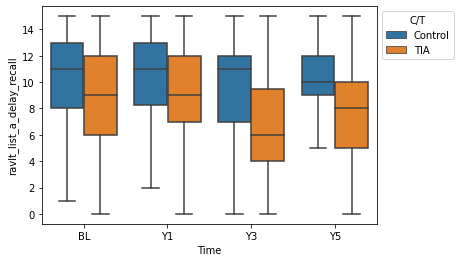

In [183]:
plot = sns.boxplot(data=score_df, x="Time", y=COG_SCORE_TEST, hue="C/T", hue_order = ["Control", "TIA"], showfliers=False)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(FIGURE_PATH+f"/new analysis/{COG_SCORE_TEST}.png", dpi=250, bbox_inches='tight')